In [2]:
cd ../utilities/

/home/gustav/Documents/DD142X/code/utilities


In [3]:
ls

features.py  matlab_util.py  plotting.py  __pycache__/  spectogram_script.py


In [4]:
from spectogram_script import load_all
from plotting import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [5]:
freqs, dataDict = load_all()
epochs = []
# Ensure sorted epochs
for session in sorted(dataDict.keys()):
    for channel in sorted(dataDict[session].keys()):
        for row in dataDict[session][channel]:
            epochs.append(row)
epochs = np.array(epochs)

loF = 5
hiF = 50
epochs = epochs[ : ,
    (freqs > loF) & (freqs < hiF)
]

print(epochs.shape)

(367629, 46)


In [6]:
# embeddings = TSNE(n_components = 2).fit_transform(epochs.copy())
embeddings = np.load("../_data/TSNE/embeddings.npy")

In [7]:
idxSum = 0
idxs = []
for session in sorted(dataDict.keys()):
    lo = idxSum
    for channel in sorted(dataDict[session].keys()):
        idxSum += dataDict[session][channel].shape[0]
    hi = idxSum
    idxs.append((session, lo, hi))
    
for s, l, h in idxs:
    print((s, l, h))

('NPR-073.d04', 0, 19475)
('NPR-073.d08', 19475, 36657)
('NPR-075.b11', 36657, 56807)
('NPR-075.b13', 56807, 77678)
('NPR-075.c013', 77678, 93911)
('NPR-075.c08', 93911, 111027)
('NPR-075.d07', 111027, 130377)
('NPR-076.b05', 130377, 145083)
('NPR-076.b09', 145083, 162839)
('NPR-076.c09', 162839, 181487)
('NPR-076.d07', 181487, 200207)
('NPR040.c12', 200207, 225039)
('NPR040.d12', 225039, 235127)
('NPR052d.05', 235127, 250667)
('NPR052e.10', 250667, 262367)
('NPR064.b08', 262367, 273259)
('NPR064.c09', 273259, 315433)
('NPR065c.10', 315433, 320353)
('NPR065e.03', 320353, 343633)
('pjx289c.01', 343633, 355213)
('pjx289e08', 355213, 367629)


In [7]:
MAXANIMALS = 21
nfig = 1
plt.figure(figsize = (6 * MAXANIMALS, 6 * MAXANIMALS))
for (s1, l1, h1) in idxs[:MAXANIMALS]:
    for (s2, l2, h2) in idxs[:MAXANIMALS]:
        plt.subplot(MAXANIMALS, MAXANIMALS, nfig)
        plt.title(f"{s1} red - {s2} blue")
        inputs1 = embeddings[l1:h1]
        inputs2 = embeddings[l2:h2]
        raster = simultaneous_raster_withbounds(inputs1, inputs2)
        raster[:,:, 0] /= np.max(raster[:,:, 0])
        raster[:,:, 2] /= np.max(raster[:,:, 2])
        plt.imshow(raster)
        nfig += 1
plt.savefig(f"../_data/TSNE/xref.png")
plt.close()

In [8]:
idxs_str = []
idxs_gp = []
idxSum = 0
for session in sorted(dataDict.keys()):
    for channel in sorted(dataDict[session].keys()):
        lo = idxSum
        idxSum += dataDict[session][channel].shape[0]
        hi = idxSum
        if "str_lfp" in channel:
            idxs_str.append((lo, hi))
        else:
            idxs_gp.append((lo, hi))  

embeddings_str = np.concatenate([
    embeddings[l:h] for l, h in idxs_str
], axis = 0)

embeddings_gp = np.concatenate([
    embeddings[l:h] for l, h in idxs_gp
], axis = 0)

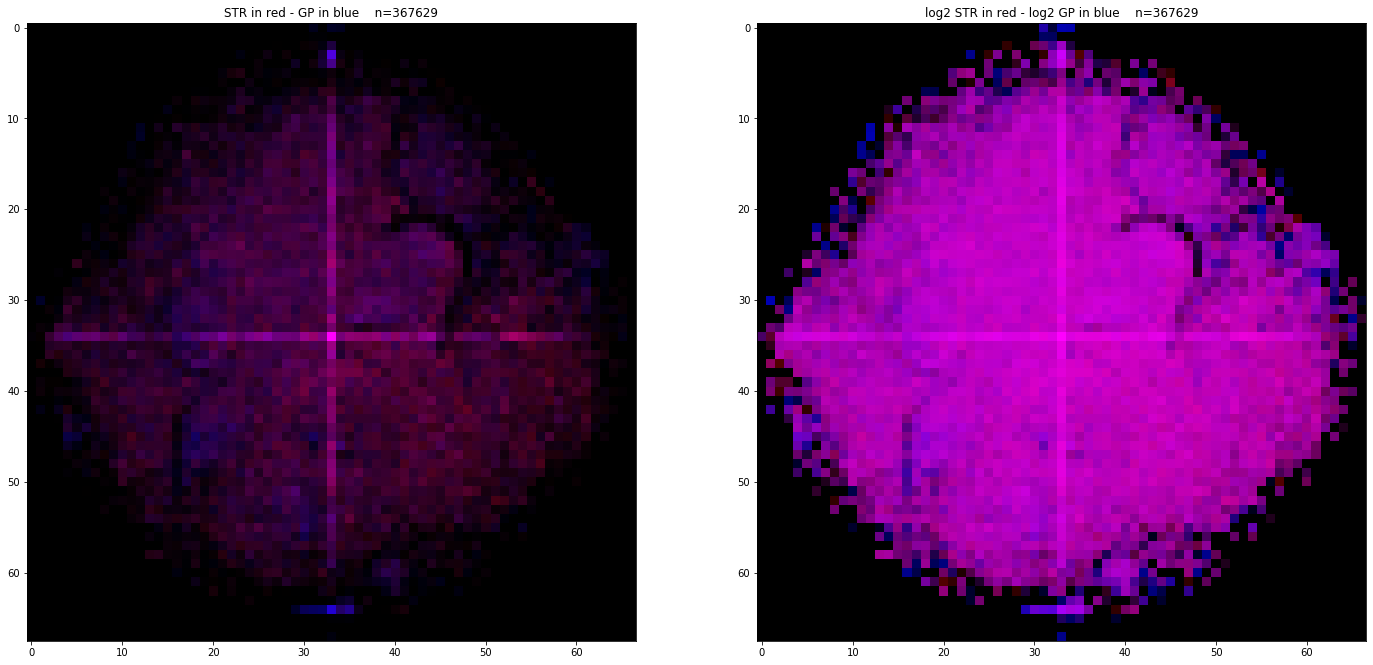

In [9]:
raster, log2raster = simultaneous_raster_withbounds(
    embeddings_str, 
    embeddings_gp,
    log2 = True
)

raster[:,:, 0] /= np.max(raster[:,:, 0])
raster[:,:, 2] /= np.max(raster[:,:, 2])
log2raster[:,:, 0] /= np.max(log2raster[:,:, 0])
log2raster[:,:, 2] /= np.max(log2raster[:,:, 2])

plt.figure(figsize = (24, 12))
plt.subplot(1, 2, 1)
plt.title(f"STR in red - GP in blue    n={embeddings.shape[0]}")
plt.imshow(raster)
plt.subplot(1, 2, 2)
plt.title(f"log2 STR in red - log2 GP in blue    n={embeddings.shape[0]}")
plt.imshow(log2raster)

plt.savefig("../_data/TSNE/STRvsGP.png")
plt.show()

In [14]:
# Select animal for visualization
for animal_idx in range(0, 21):
    # Animal, indexes for animal within embeddings
    epoch_animal, loidx, hiidx = idxs[animal_idx]
    epoch_animal_data = dataDict[epoch_animal]
    # Amount of channels for animal, amount of epochs for animal
    n_channels = len(epoch_animal_data.items())
    n_epochs = int((hiidx - loidx) / n_channels)
    # Select embeddings
    epoch_animal_embeddings = embeddings[loidx : hiidx]
    # Reshape to (channels, epochs, (x1, x2)) 
    epoch_animal_embeddings = epoch_animal_embeddings.reshape((n_channels, n_epochs, 2))
    # GP / STR indexing
    n_gp  = len([k for k in dataDict[epoch_animal].keys() if  "gp_lfp" in k])
    n_str = len([k for k in dataDict[epoch_animal].keys() if "str_lfp" in k])
    
    # Epochs per figure
    max_epoch = 5
    # Amount of figures
    for j in range(0, 100):  
        # Per-epoch colors
        cols = [
            'green', 'blue', 'purple', 'red', 'orange'
        ]
        # Set figure size
        plt.figure(figsize = (10, 10))
        # For epoch, color
        for e, c in zip(
            range(j * max_epoch, (j + 1 ) * max_epoch),
            cols
        ):

            # Ensure plot bounds have decent range
            plt.plot(
                [-30, -30, 30, 30],
                [30, -30, 30, -30],
                'w.'
            )

            # GP plotting
            plt.plot(
                [x for x, _ in epoch_animal_embeddings[ : n_gp, e, : ]],
                [y for _, y in epoch_animal_embeddings[ : n_gp, e, : ]],
                'x',
                color = 'tab:' + c,
            )

            # STR plotting
            plt.plot(
                [x for x, _ in epoch_animal_embeddings[n_gp : , e, : ]],
                [y for _, y in epoch_animal_embeddings[n_gp : , e, : ]],
                '+',
                color = 'tab:' + c,
            )

            # Mean absolute deviation from mean - centroid
            epoch_mean = epoch_animal_embeddings[ : , e, : ].mean(axis = 0)
            epoch_mad  = np.abs(
                epoch_animal_embeddings[ : , e, : ] - epoch_mean
            ).mean(axis = 0)
            
            angles = np.linspace(-np.pi, np.pi, 100)
            plt.plot(
                [epoch_mean[0] + epoch_mad[0] * np.cos(a) for a in angles],
                [epoch_mean[1] + epoch_mad[1] * np.sin(a) for a in angles],
                c,
                alpha = 0.2,
            )

        plt.title(
            f"Epochs {j * max_epoch + 1} - {(j+1)*max_epoch + 1} for {epoch_animal}\
            \nColor order: green - blue - purple - red - orange\
            \nGP: x, STR: +         n channels per epoch: {n_gp} GP, {n_str} STR\
            \nCentroid visualizes mean absolute deviation from mean"
        )

        from os import mkdir
        try:
            mkdir(f"../_data/TSNE/epochs/{epoch_animal}/")
        except:
            pass

        plt.savefig(f"../_data/TSNE/epochs/{epoch_animal}/epochs{j*max_epoch+1}-{(j+1)*max_epoch+1}.png")
        plt.close()